# **Data Cleaning**

## Objectives

* Clean the data by handling missing values and ensuring correct data types.
* Standardize numerical features to improve consistency and model training.
* Save the cleaned dataset for further analysis and modeling.

## Inputs

* outputs/datasets/collection/HousePricesRecords.csv`: The raw collected data from the Data Collection step

## Outputs

* outputs/datasets/cleaned/HousePricesCleaned.csv`: The cleaned data, ready for feature engineering and analysis

---

# Change working directory

* The notebooks are stored in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

## Load data

**Load the data** from the generated CSV file to inspect data types and preview the dataset structure.

In [3]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv")
df.head


<bound method NDFrame.head of       1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0        856.0     854.0           3.0           No       706.0          GLQ   
1       1262.0       0.0           3.0           Gd       978.0          ALQ   
2        920.0     866.0           3.0           Mn       486.0          GLQ   
3        961.0       NaN           NaN           No       216.0          ALQ   
4       1145.0       NaN           4.0           Av       655.0          GLQ   
...        ...       ...           ...          ...         ...          ...   
1455     953.0     694.0           3.0           No         0.0          Unf   
1456    2073.0       0.0           NaN           No       790.0          ALQ   
1457    1188.0    1152.0           4.0           No       275.0          GLQ   
1458    1078.0       0.0           2.0           Mn        49.0          NaN   
1459    1256.0       0.0           3.0           No       830.0          BLQ   

      Bsm

**Visualize missing values** to easily identify which columns have missing data

In [4]:
# Evaluate the proportion of missing values per column
def evaluate_missing_data(df):
    missing_data = df.isnull().sum()
    percentage_missing = (missing_data / len(df)) * 100
    missing_summary = pd.DataFrame({
        "MissingValues": missing_data,
        "PercentageMissing": percentage_missing
    })
    print("\nMissing values per column:")
    print(missing_summary[missing_summary["MissingValues"] > 0])

# Call the function to evaluate missing values
evaluate_missing_data(df)


Missing values per column:
               MissingValues  PercentageMissing
2ndFlrSF                  86           5.890411
BedroomAbvGr              99           6.780822
BsmtExposure              38           2.602740
BsmtFinType1             145           9.931507
EnclosedPorch           1324          90.684932
GarageFinish             235          16.095890
GarageYrBlt               81           5.547945
LotFrontage              259          17.739726
MasVnrArea                 8           0.547945
WoodDeckSF              1305          89.383562


**Visualize** which columns have missing data and how much is missing, making it easier to decide on handling strategies.

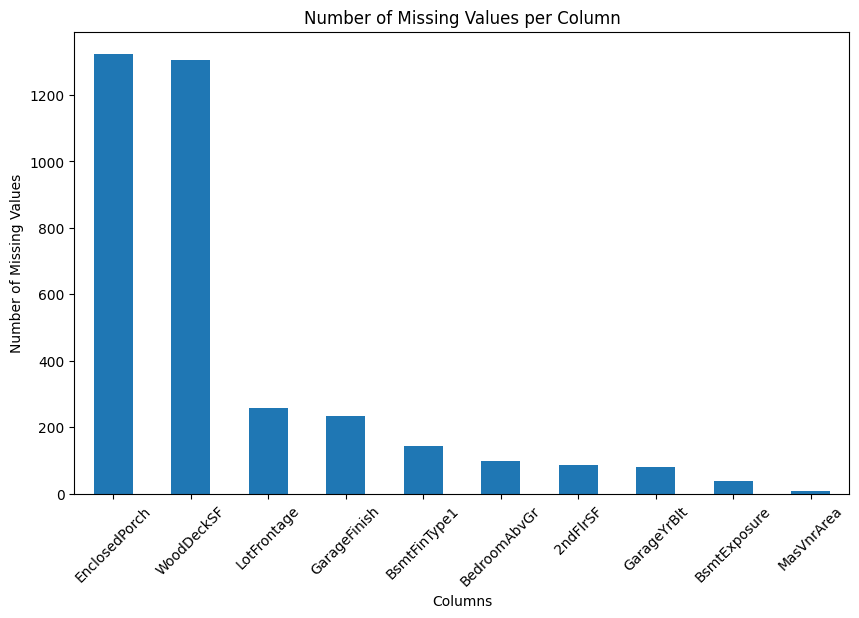

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary of missing values sorted in descending order
missing_data_summary = df.isnull().sum().sort_values(ascending=False)
missing_data_summary = missing_data_summary[missing_data_summary > 0]  # Include only columns with missing values

# Bar plot showing the number of missing values per column
plt.figure(figsize=(10, 6))
missing_data_summary.plot(kind='bar')
plt.title('Number of Missing Values per Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()


**Columns like 'EnclosedPorch' and 'WoodDeckSF' have over 89% missing values and will be removed because they do not directly impact the model or business goal.**

In [6]:
# Drop columns with high missing values that are not relevant
columns_to_drop = ['EnclosedPorch', 'WoodDeckSF']
df.drop(columns=columns_to_drop, inplace=True)

print(f"Removed columns: {columns_to_drop}")

Removed columns: ['EnclosedPorch', 'WoodDeckSF']


**Remove duplicates**

Remove duplicates to keep data clean and avoid repeated information that could harm model accuracy.

In [7]:
df.drop_duplicates(inplace=True)
print(f"Duplicates after cleaning: {df.duplicated().sum()}")
print(f"Shape of data after removing duplicates: {df.shape}")

Duplicates after cleaning: 0
Shape of data after removing duplicates: (1460, 22)


**Handle missing data to:**
* Improve Model Performance
* Better Data Quality

Filling in missing values prevents errors in model training and prediction. Handling missing data is important to ensure the dataset is complete.


In [8]:
# Fill in missing numerical columns with the median
numerical_features = df.select_dtypes(include=['number']).columns
df[numerical_features] = df[numerical_features].apply(lambda x: x.fillna(x.median()))

# Fill in missing categorical columns with the most common category
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].apply(lambda x: x.fillna(x.mode()[0]))

# Check if there are any missing values left
print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values after cleaning:
1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64


Used **log transformation** to reduce skewness in data, helping improve model accuracy.

In [9]:
import numpy as np

# Apply log transformation to features with strong skewness
skewed_features = ['LotArea', 'SalePrice', 'MasVnrArea']

for feature in skewed_features:
    df[feature] = np.log1p(df[feature])  # Use log1p to handle zero values as well

Used **Box-Cox transformation** to reduce skewness in positive features, making the data more normal for better model results.

In [10]:
from scipy.stats import boxcox

# Only positive values can be used for Box-Cox transformation
for feature in skewed_features:
    if (df[feature] > 0).all():
        df[feature], _ = boxcox(df[feature])

Used **StandardScaler** to scale numerical features, putting them on the same scale to improve model training.

In [11]:
from sklearn.preprocessing import StandardScaler

# Select the numerical features
numerical_features = df.select_dtypes(include=['number']).columns

# Create a StandardScaler instance and scale the data
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

**Visualize outliers** to identify potential data issues
Helps decide if handling outliers is needed later


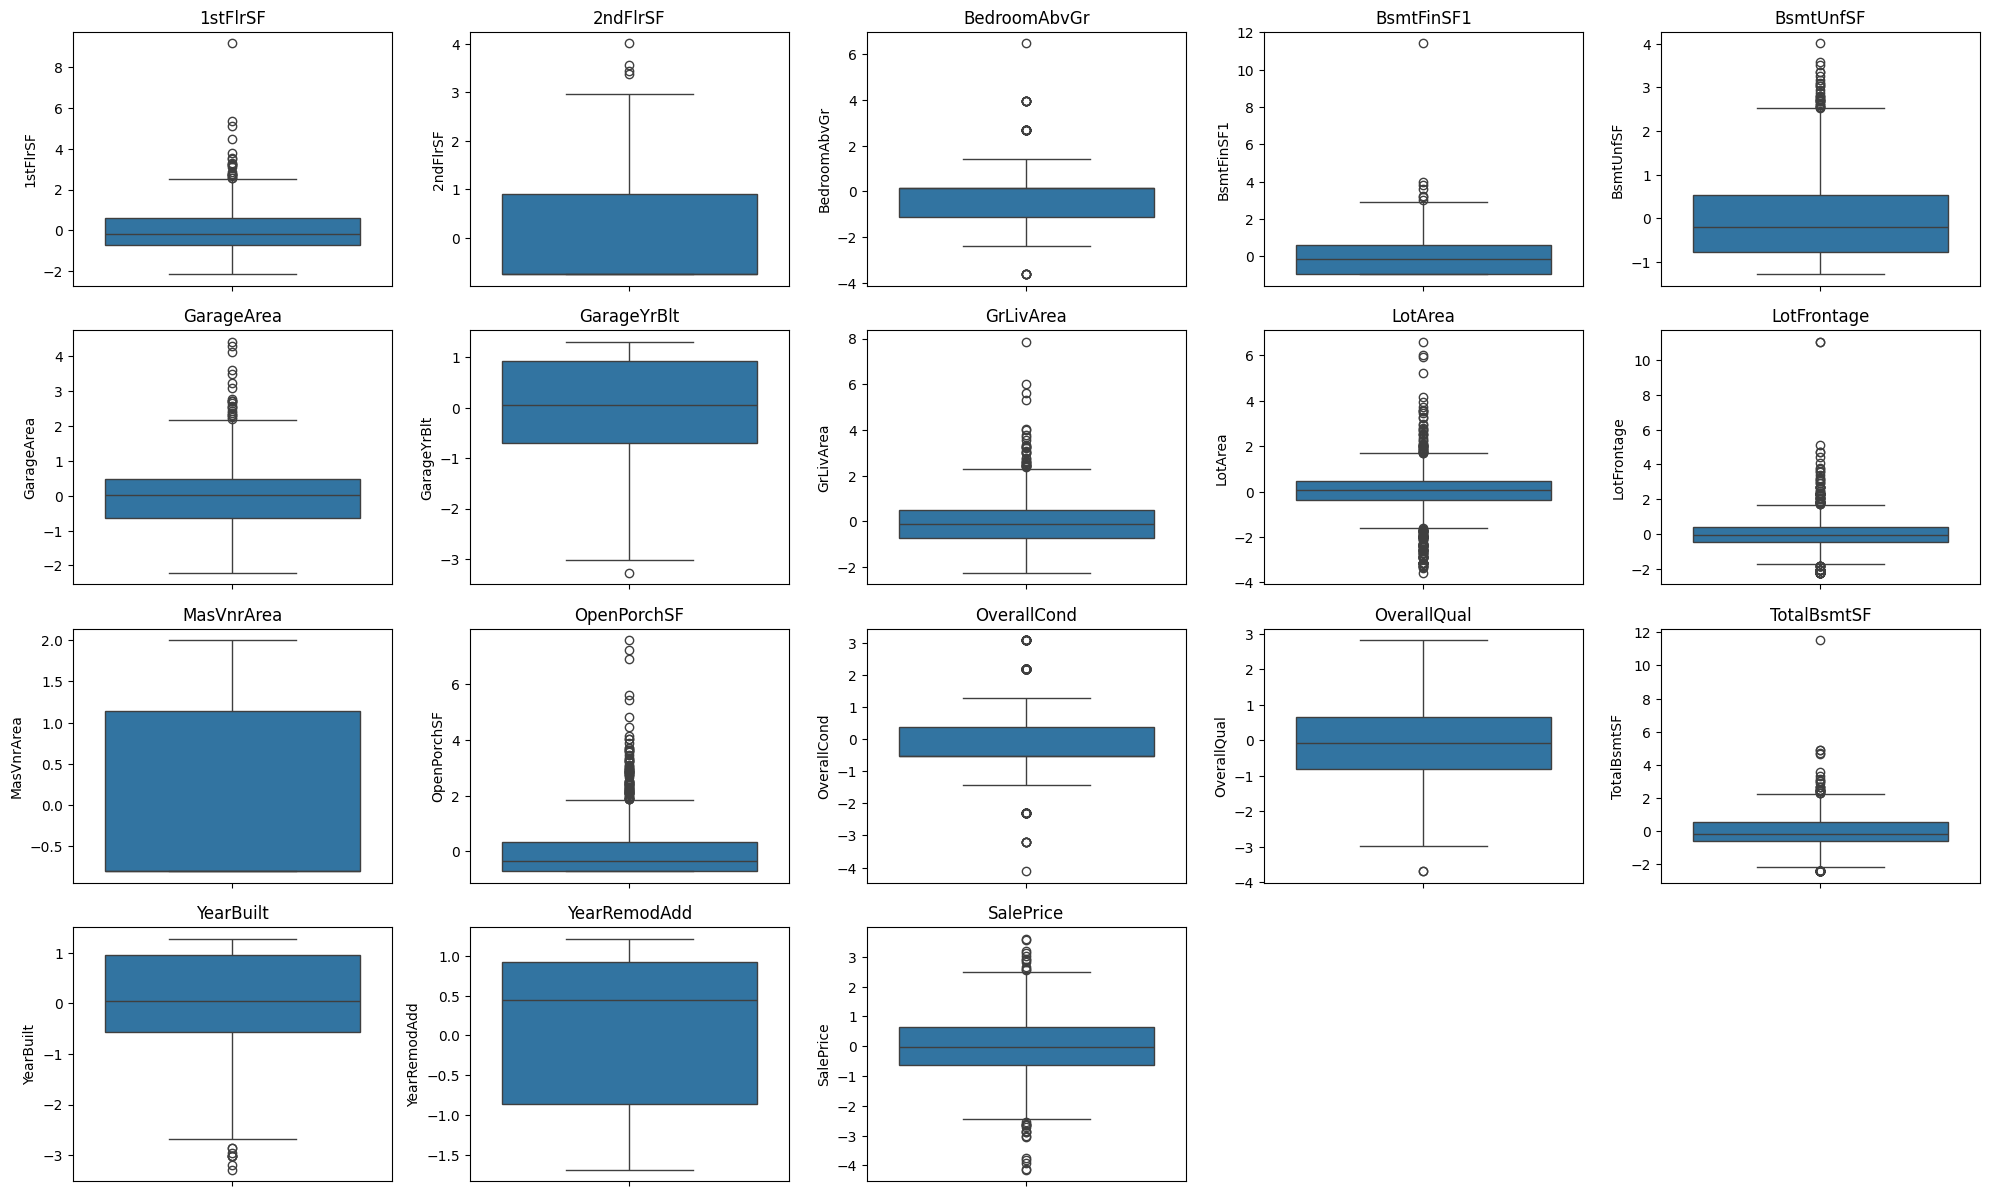

In [12]:
# Visualize outliers with boxplot for numerical features
numerical_features = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(y=df[feature])
    plt.title(f'{feature}')

plt.tight_layout()
plt.show()


**There were extreme outliers. After transformations, outliers are still present but reduced. Data distribution is now more balanced, which help improve model performance.**



___

**Convert object to category to:**

* Save Memory
* Make Models Faster

Changing object columns to category types can save memory and make model training faster, especially when they have only a few unique values.

In [13]:
df['BsmtExposure'] = df['BsmtExposure'].astype('category')
df['BsmtFinType1'] = df['BsmtFinType1'].astype('category')
df['GarageFinish'] = df['GarageFinish'].astype('category')
df['KitchenQual'] = df['KitchenQual'].astype('category')


**matplotlib was used to create histograms of the dataset**

Histograms are used to visualize the data after cleaning. This helps to verify if the cleaning steps were effective and identify any remaining patterns or issues in the data.

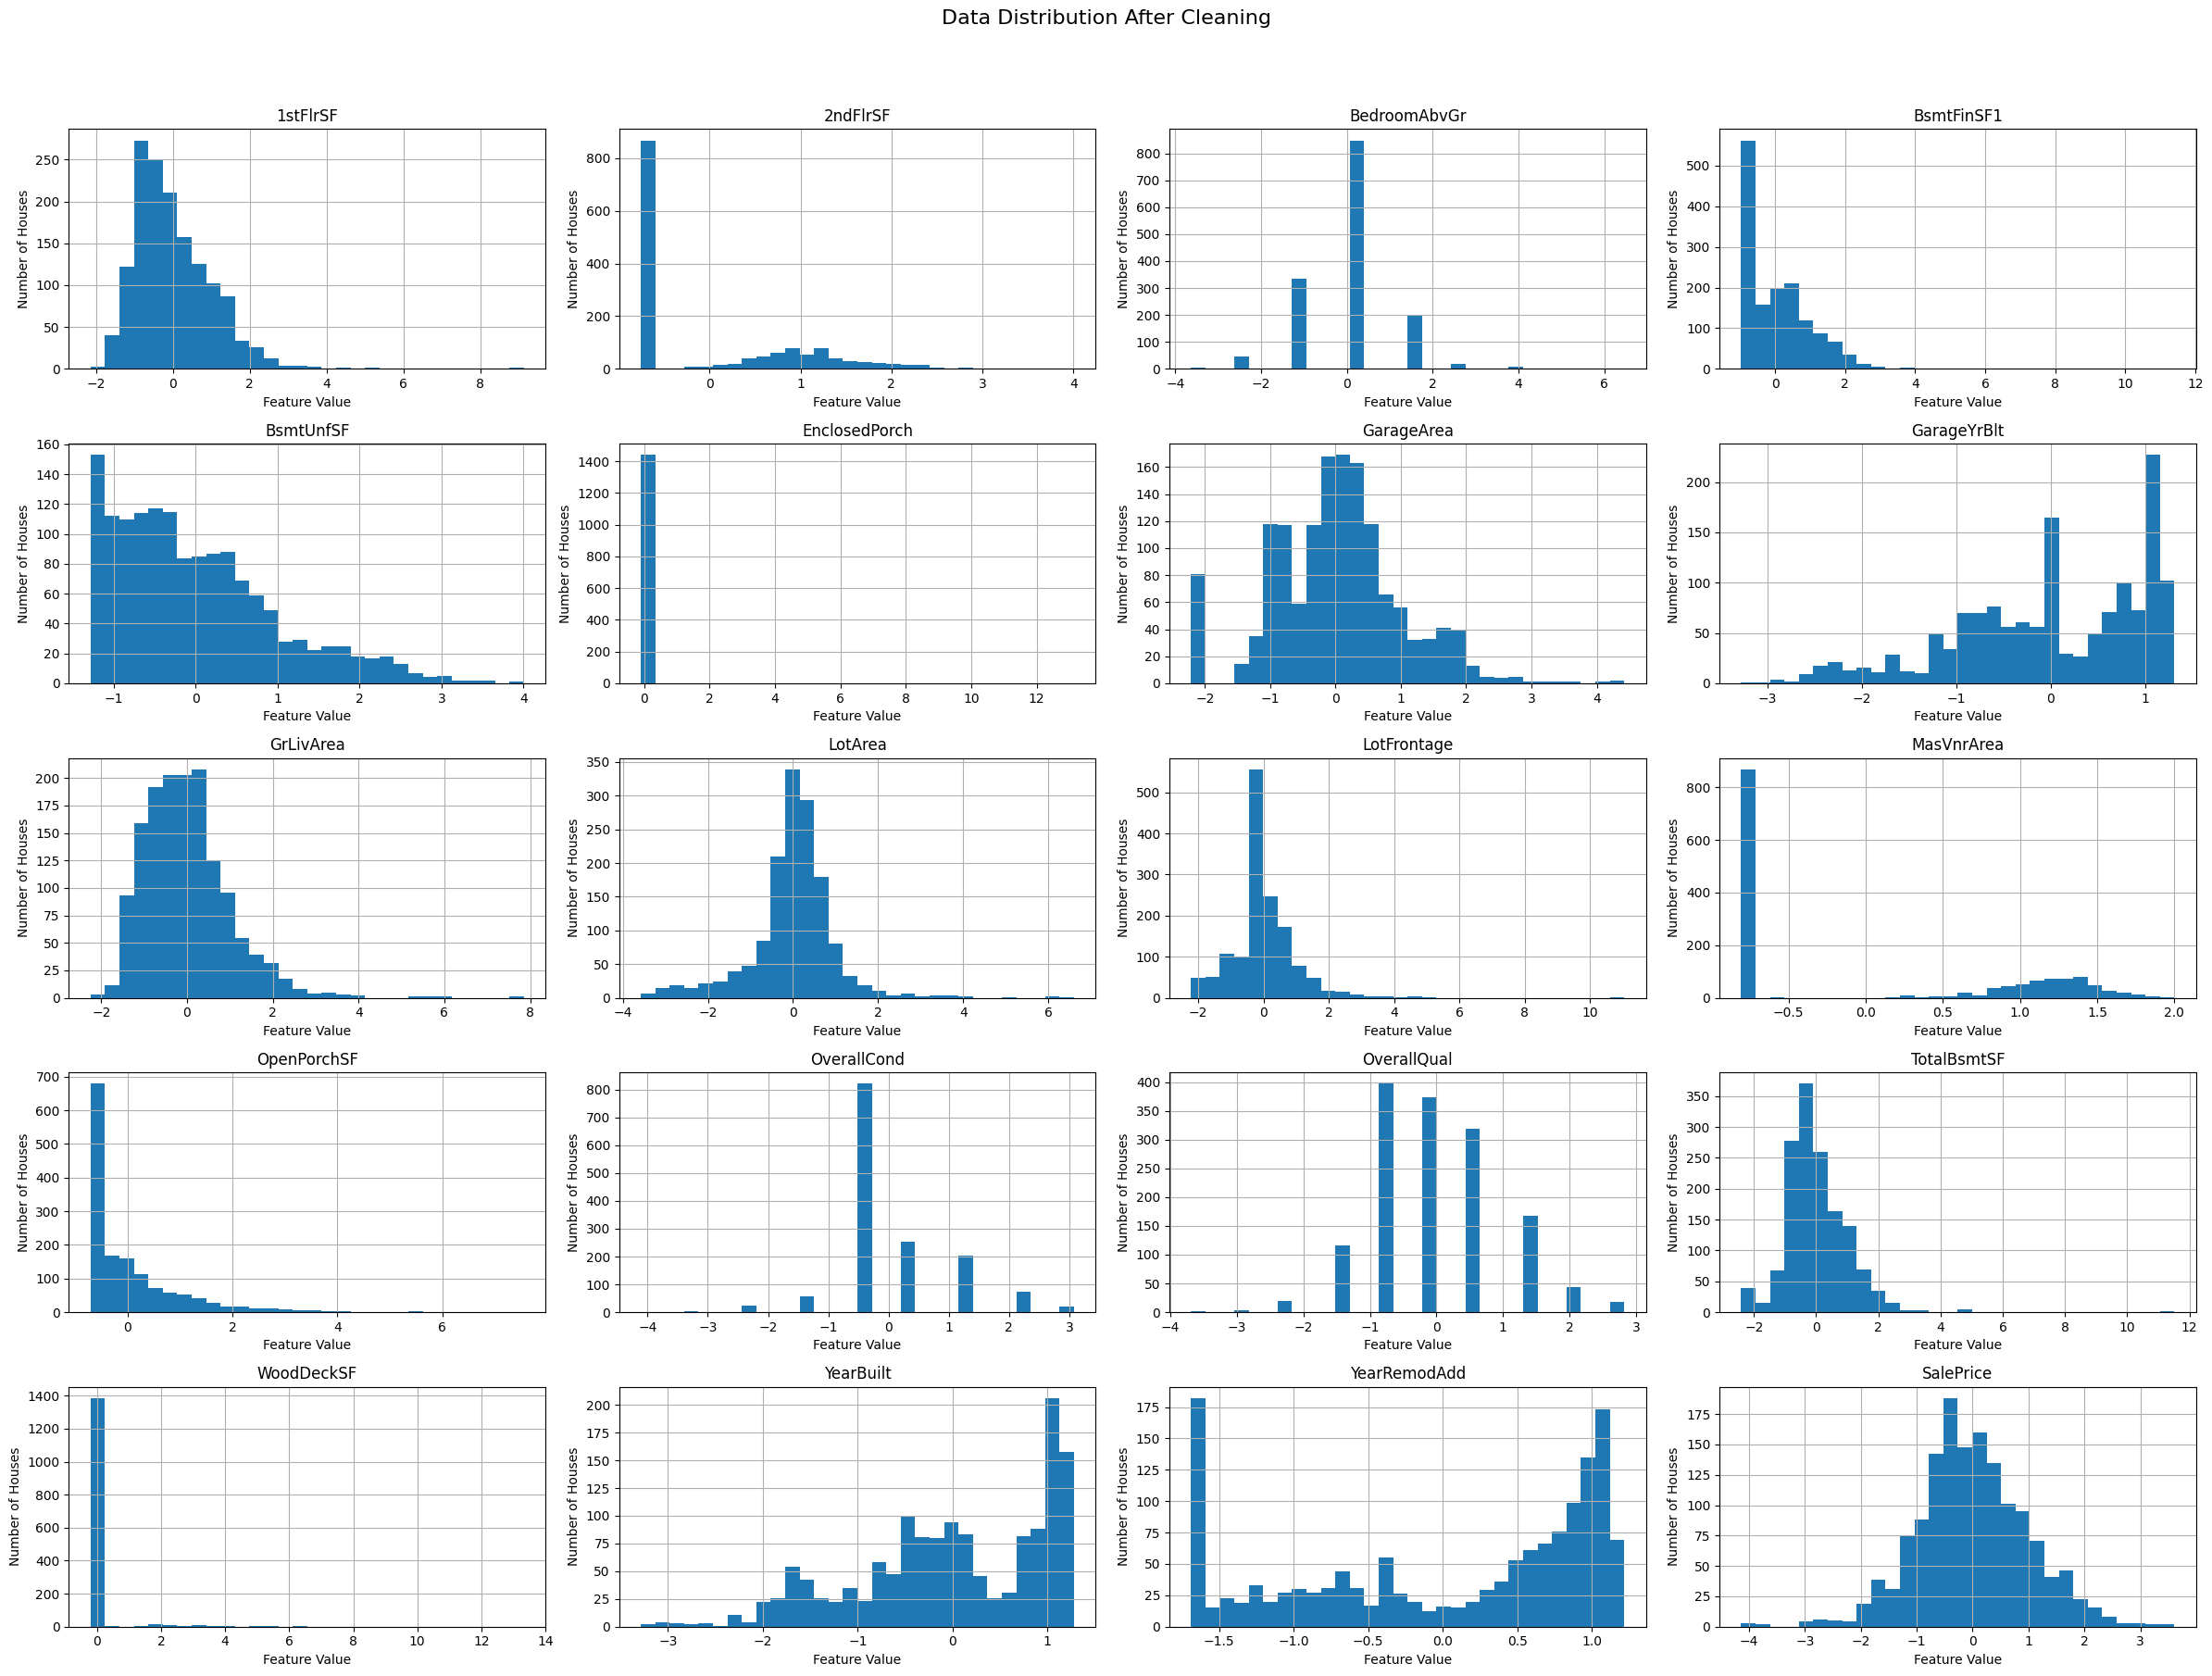

In [14]:
import matplotlib.pyplot as plt


df.hist(bins=30, figsize=(24, 19))
plt.suptitle("Data Distribution After Cleaning", fontsize=16)

for ax in plt.gcf().axes:
    ax.set_xlabel("Feature Value")
    ax.set_ylabel("Number of Houses")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



**Features like 'LotArea' and 'MasVnrArea' had skewed distributions. After transformations, they are more balanced, making them better for modeling.**

___

___

**Check data types**

df.dtypes is used after visualizing data to confirm each column's data type after cleaning, ensuring all transformations were correctly applied before further analysis.

In [15]:
df.dtypes

1stFlrSF          float64
2ndFlrSF          float64
BedroomAbvGr      float64
BsmtExposure     category
BsmtFinSF1        float64
BsmtFinType1     category
BsmtUnfSF         float64
EnclosedPorch     float64
GarageArea        float64
GarageFinish     category
GarageYrBlt       float64
GrLivArea         float64
KitchenQual      category
LotArea           float64
LotFrontage       float64
MasVnrArea        float64
OpenPorchSF       float64
OverallCond       float64
OverallQual       float64
TotalBsmtSF       float64
WoodDeckSF        float64
YearBuilt         float64
YearRemodAdd      float64
SalePrice         float64
dtype: object

___

## Push files to repo

In [16]:
df.to_csv("outputs/datasets/collection/HousePricesCleaned.csv", index=False)
print("Exported the transformed dataset successfully!")

Exported the transformed dataset successfully!


### Data Cleaning Summary
* Missing Values: Filled missing numbers with the median and missing categories with the most common value. Removed columns with too many missing values.
* Skewness Transformation: Used log and Box-Cox to make data more normal.
* Standardization: Scaled all numbers to be on the same scale with StandardScaler.
* Type Conversion: Changed text columns to categories to save memory.
* Visualization: Used boxplots and histograms to check data after cleaning.
* Export: Saved the cleaned data for further analysis.